In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time

import torch
import matplotlib.font_manager
import res_utils as ru
from scipy.ndimage.interpolation import shift
from PIL import ImageFont

import sys
sys.path.append("..")
from scae.util import vis

In [2]:
%matplotlib inline
# plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'text.usetex': False})
# matplotlib.rcParams['text.latex.preamble'] = [
#     r'\usepackage{amsmath}',
#     r'\usepackage{amssymb}']
# plt.rcParams.update({'font.family': 'serif'})
# plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})

np.set_printoptions(precision=3)

In [3]:
# You might want to see the fonts on your system and choose a different font
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')


In [4]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

# Factorization of shape, color and location

In this notebook, we are going to set up a simple scene analysis problem that can be solved with the resonator network. This example generates a scene by combining several factors to create an object: the object is a conjunction of shape, color and location. The shapes of the objects are given by fixed templates (letters chosen from a font). The goal will be to use VSA principles and resonator networks to infer the factors of each object from the scene.

First, lets get some letters for the scene.

In [5]:
# This will determine the size of the scene
patch_size=[56, 56]

torch.Size([26, 3, 56, 56])

<Figure size 432x288 with 0 Axes>

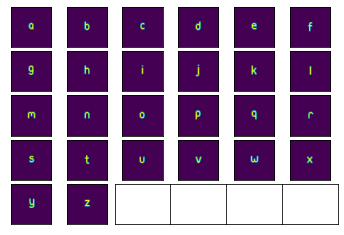

In [6]:

#font = ImageFont.load_default().font
#font = ImageFont.load_path(u'/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf').font
#font = ImageFont.truetype( u'/usr/share/fonts/truetype/ttf-dejavu/DejaVuSans.ttf', size=18)
font =  ImageFont.truetype(u'Ubuntu-Title.ttf', size=18)
letters = 'abcdefghijklmnopqrstuvwxyz'

font_ims = []
fim_size = (patch_size[0],patch_size[1],3)

for l in letters:

    font_obj = font.getmask(l)
    
    imtext = np.array(font_obj)
    imsize = font_obj.size #font.getsize(l)

    imtext = np.tile(imtext.reshape((imsize[1], imsize[0], 1)), (1,1,3))
    imtext = imtext[:patch_size[0], :patch_size[1], :]
    
    imsize = imtext.shape
    
    fim = np.zeros(fim_size)
    
    fimr = int(np.floor((fim_size[0] - imsize[0])/2))
    fimc = int(np.floor((fim_size[1] - imsize[1])/2))
    
    fim[fimr:(fimr+imsize[0]), fimc:(fimc+imsize[1]), :] = imtext/255
    
    font_ims.append(fim)

t_font_ims = torch.Tensor(font_ims).permute(0, 3, 1, 2)
vis.plot_image_tensor(t_font_ims)
t_font_ims.shape

## Encoding locations with the exponentiation trick

The first step of the scene analysis is to encode the scene into a high-dimensional VSA vector. This VSA encoding has some special properties. The first is that the encoding vectors for the pixels are designed in a special way such that the properties of translation are available as a simple operation. 

Translating the scene in this fashion is possible because the pixels are encoded using the "exponentiation trick", where each pixel position is encoded by a single base vector raised to a power. For example, the vertical position 10 is encoded as $V^{10}$. Similarly, the horizontal position has base vector and is also exponentiated by the pixel location. The 2-D location is then indexed as the binding between the vector encodings, e.g. the position 10, 20 is given by $V^{10} \odot H^{20}$.


In [7]:
N = int(3e4)

# These are special base vectors for position that loop
Vt = ru.cvec(N, font_ims[0].shape[0])
Ht = ru.cvec(N, font_ims[0].shape[1])

# This is a set of 3 independently random complex phasor vectors for color
Cv = ru.crvec(N, 3)

In [8]:
def encode_pix(im, Vt, Ht):
        N = Vt.shape[0]

        image_vec = 0.0 * ru.cvec(N, 1)

        for m in range(im.shape[0]):
            for n in range(im.shape[1]):
                P_vec = Vt[m] * Ht[m]
                image_vec += P_vec * im[m, n]

        return image_vec

def encode_pix_rgb(im, Vt, Ht, Cv):
    N = Vt.shape[0]

    image_vec = torch.as_tensor(0.0 * ru.cvec(N, 1), dtype=torch.cfloat).cuda()
    for m in range(im.shape[0]):
        Vt_m__Ht_n = Vt ** m * Ht ** 0
        for n in range(im.shape[1]):
            for c in range(im.shape[2]):
                P_vec = Cv[c] * Vt_m__Ht_n
                image_vec += P_vec * im[m, n, c]
            Vt_m__Ht_n *= Ht


    return image_vec

def decode_pix(image_vec, Vt, Ht):
    N = Vt.shape[0]
    im_r = np.zeros(fim_size)

    for m in range(im_r.shape[0]):
        for n in range(im_r.shape[1]):
            P_vec = (Vt ** m) * (Ht ** n)
            im_r[m, n] = np.real(np.dot(np.conj(P_vec), image_vec)/N)
    return np.clip(im_r, 0, 1)

def decode_pix_rgb(image_vec, Vt, Ht, Cv):
    N = Vt.shape[0]
    im_r = torch.zeros(fim_size).cuda()

    for m in range(im_r.shape[0]):
        Vt_m__Ht_n = Vt ** m * Ht ** 0
        for n in range(im_r.shape[1]):
            for c in range(im_r.shape[2]):
                P_vec = Cv[c] * Vt_m__Ht_n
                im_r[m, n, c] = torch.real(torch.dot(torch.conj(P_vec), image_vec)/N)
            Vt_m__Ht_n *= Ht
    return torch.clip(im_r, 0, 1)

In [80]:
class VSA:
    def __init__(self, Vt, Ht, Cv, imshape=patch_size, device="cuda"):
        self.Vt = torch.as_tensor(Vt, dtype=torch.cfloat).to(device)
        self.Ht = torch.as_tensor(Ht, dtype=torch.cfloat).to(device)
        self.Cv = torch.as_tensor(Cv, dtype=torch.cfloat).to(device)
        
        # VSA vec length
        self.V = self.Cv.shape[-1]
        Hr = torch.range(0, imshape[0]-1).to(device)[:, None, None, None].expand(imshape[0], 1, 1, self.V)
        Vr = torch.range(0, imshape[1]-1).to(device)[None, :, None, None].expand(1, imshape[1], 1, self.V)
        
        self.P_vec = self.Ht[None, None, None, :].expand(1, imshape[1], 1, self.V).pow(Hr) \
                    * self.Vt[None, None, None, :].expand(imshape[0], 1, 1, self.V).pow(Vr) \
                    * self.Cv[None, None, :, :]
        
        # Position "hashing" vectors (Verticals, Horizontals, Channels, VSA vec lengths)
        print(f"P_vec shape: {self.P_vec.shape}")
        self.device = device
        
    def encode_pix(self, im):
        # Weighted sum of all P_vectors over pixels and channels (superposition of pixel values, embedded with P_vec)
        return (self.P_vec.T * im.T).reshape(self.V, -1).sum(-1).T

    def decode_pix(self, image_vec):
        # Selects pixel value by dotting VSA vec with conjugate of position encoding, and taking real component (clip for stability)
        # Old elementwise formula: return_img[m, n, c] = torch.real(torch.dot(torch.conj(self.P_vec[m, n, c]), image_vec) / self.R)
        return torch.clip(torch.real(torch.conj(self.P_vec) * image_vec[None, None, None, :]).sum(-1) / self.V, 0, 1)


In [78]:
print(font_ims[0].shape, Vt.shape, Ht.shape, Cv.shape)
with torch.no_grad():
    vsa = VSA(Vt[0], Ht[0], Cv, device='cuda')
    
    total = len(font_ims)
    total_encode = 0.
    total_decode = 0.
    ims = []
    reps = []
    recs = []
    
    for i, im in enumerate(font_ims):
        input_img = torch.as_tensor(im, dtype=torch.float).cuda()
        ims.append(input_img.cuda())

        tst = time.time()
        f_vec = vsa.encode_pix(input_img)
        total_encode += time.time() - tst
        reps.append(f_vec)
        
        # translate the image
        f_vec_tr = f_vec * vsa.Vt**i * vsa.Ht**i

        tst = time.time()
        f_im = vsa.decode_pix(f_vec_tr)
        total_decode += time.time() - tst
        recs.append(f_im.cpu())
    
    f_vec_composite = reps[0] * vsa.Vt**-15 + reps[1] + reps[2] * vsa.Ht**15 + reps[3] * vsa.Vt**15 * vsa.Ht**15
    tst = time.time()
    f_im = vsa.decode_pix(f_vec_composite)
    print(f"composite decode time: {time.time() - tst:.3}s") 
    plt.imshow(f_im.cpu())
    plt.show()

    print(f"avg encode time: {total_encode/total:.3}s")
    print(f"avg decode time: {total_decode/total:.3}s")
    vis.plot_image_tensor(torch.stack(ims).permute(0, 3, 1, 2))
    vis.plot_image_tensor(torch.stack(recs).permute(0, 3, 1, 2))
#     plt.show()
    
    del vsa
    torch.cuda.empty_cache()
#     print(torch.cuda.memory_stats(device=None))

(56, 56, 3) (56, 30000) (56, 30000) torch.Size([3, 30000])


/home/axquaris/.conda/envs/crystalize/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  if __name__ == '__main__':
/home/axquaris/.conda/envs/crystalize/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # Remove the CWD from sys.path while we load stuff.


AttributeError: 'VSA' object has no attribute 'R'

## A toroidal image encoding

There is a second special property to these vectors, which enables treating the image like a torus -- as we translate to the right and move off of the right side of the image, we will end up on the left side. Same for top and bottom. For this to be possible, we design the base vectors by considering the identity vector and the roots of the identity vector.

What is the identity vector? Since the operation we are considering is element-wise multiply, the identity vector is simply a vector where each entry is 1. 

When we apply the exponentiation trick to a root of the identity vector, then as we increase the exponent, we will eventually go in a loop. We choose the order of the root based on how long we want the loop to be. If we choose a square root of the identity, then we will loop every two steps. If we choose the 4th root, we will loop every 4 steps. Here, we chose a loop the size of the image -- 56 pixels.

What are the roots of the identity vector? Of course, the square roots of 1 are (+1, -1). The 4th roots of 1 are (1, i, -1, -i). The N-th root of 1 are the $N$ points around the complex plane: $e^{2 \pi i k / N} \forall k = 1, ..., N$. Thus, to form a VSA vector that will loop when raised to the $N$-th power, we choose one of the $N$ roots of identity randomly for each entry of the vector. This is implemented by the function $\verb|cvecl|$.


In [ ]:
loop_size = 10
loop_vec = ru.cvec(N, loop_size)[0]

pows = np.linspace(-15, 15, 200)
sims = np.zeros_like(pows)

for i, p in enumerate(pows):
    sims[i] = np.real(np.dot(np.conj(loop_vec).T, loop_vec ** p)) / N
                      
plt.plot(pows, sims)
plt.xlabel('Exponent')
plt.ylabel('Similarity')

plt.tight_layout()

Here, we are examining the similarity between a loop vector and its powers. What we see is high similarity at power 1, as well as at powers 11, and -9. Because we designed the vector based on the roots, we can control how long it takes for it to loop!

Note here we are also exponentiating the vectors by fractional powers -- we have the ability to perform fractional binding in the complex domain! This means that as we incremenet the exponent slightly we move smoothly along a manifold in the high-dimensional vector space. 

In [ ]:
loop_size = 1000
loop_vec = ru.cvec(N, loop_size)[0]

pows = np.linspace(-15, 15, 200)
sims = np.zeros_like(pows)

for i, p in enumerate(pows):
    sims[i] = np.real(np.dot(np.conj(loop_vec).T, loop_vec ** p)) / N
                      
plt.plot(pows, sims)

# compare to the sinc function
plt.plot(pows+1, np.sin(np.pi*pows)/(np.pi*pows))

plt.xlabel('Exponent')
plt.ylabel('Similarity')

plt.tight_layout()

If we choose a very large loop size (or equivalently a completely random complex VSA vector), then we see a very special curve appear -- the sinc function. 

## Dealing with correlations

Now that we have a way to encode position (that is smooth and can loop), we next need to consider how to deal with encoding of shape and color. 

The representation for the shape of the object will be linked closely to the representation of pixel location. In essence, the shape of the object is the set of pixel locations that are active. Thus the representation of a particular letter will be the sum of the vector encoding of each pixel location. 

However, the issue that arises is that the shapes of the different objects are actually correlated. Conceptually, we want each letter to act as a symbol, meaning that it is orthogonal to the other letters. But the objects share many features in the pixel space. These correlations in the pixel space will cause issues with the resonator network when trying to solve the factorization problem. The solution to this issue is to use whitening on the patterns. Whitening orthogonalizes the patterns by adjusting the pixel magnitudes based on how many pixels are shared across letters. 


In [ ]:
def svd_whiten(X):

    U, s, Vh = np.linalg.svd(X, full_matrices=False)

    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white
    X_white = np.dot(U, Vh)

    return X_white

In [ ]:
font_im_vecs = np.zeros((len(font_ims), np.prod(font_ims[0].shape[:2])))

for i in range(len(font_ims)):
    font_im_vecs[i, :] = font_ims[i].mean(axis=2).ravel()


In [ ]:
plt.figure(figsize=(20,6))
for i in range(26):
    plt.subplot(3, 9, i+1)
    plt.imshow(font_im_vecs[i].reshape(font_ims[0].shape[:2]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
font_ims_w = svd_whiten(font_im_vecs.T).T
plt.figure(figsize=(20,6))
for i in range(26):
    plt.subplot(3, 9, i+1)
    plt.imshow(font_ims_w[i].reshape(font_ims[0].shape[:2]))
    plt.xticks([])
    plt.yticks([])

The whitened shapes look similar to the original shape with certain pixel emphasized or de-emphasized. We can see now that the shapes are orthogonalized.

In [ ]:
original_xcorr = np.dot(font_im_vecs, font_im_vecs.T)
whiten_xcorr = np.dot(font_ims_w, font_ims_w.T)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(original_xcorr)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(whiten_xcorr)
plt.xticks([])
plt.yticks([])


Now we will just encode the templates and the decorrelated templates into a vector. Note that we are not considering the colors and just using the pixel locations for the encoding.

In [ ]:
font_vecs = ru.crvec(N, len(font_ims))
tst = time.time()
for i in range(len(font_ims)):
    print(i, end=" ")
    font_vecs[i,:] = encode_pix(font_ims[i].mean(axis=2), Vt[0], Ht[0])
print("elapsed:", time.time() - tst)
# this is stupidly slow, can be implemented by just a matrix multiply 
# instead of a loop for better speed (need to store big matrix in memory though)

In [ ]:
font_vecs_w = ru.crvec(N, len(font_ims))
tst = time.time()
for i in range(len(font_ims)):
    print(i, end=" ")
    font_vecs_w[i,:] = encode_pix(font_ims_w[i].reshape(font_ims[0].shape[:2]), Vt[0], Ht[0])
print("elapsed:", time.time() - tst)

In a similar fashion to the letters, we will also consider color as a factor. Further, we will use 7 different colors. But hmm... 7 colors can't all be orthogonal because color is only a 3 dimensional space! 

The whitening still has an effect, and is still necessary.

In [ ]:
colors_dict = {'red': [1, 0, 0], 'green': [0, 1, 0], 'blue': [0, 0, 1], 'cyan': [0, 1, 1],
          'magenta':[1,0,1], 'yellow': [1, 1, 0], 'white': [1, 1, 1]}

In [ ]:
colors_arr = np.array(list(colors_dict.values()))
colors_lab = np.array(list(colors_dict.keys()))

In [ ]:
cols_im = np.tile(colors_arr.reshape([1, colors_arr.shape[0], colors_arr.shape[1]]), [10, 1, 1])
plt.imshow(cols_im*255, interpolation='none')

In [ ]:
colors_svd = svd_whiten(colors_arr)

In [ ]:
cols_svd_im = np.tile(colors_svd.reshape([1, colors_svd.shape[0], colors_svd.shape[1]]), [10, 1, 1])
plt.imshow(norm_range(cols_svd_im), interpolation='none')

In [ ]:
color_vecs = np.dot(colors_arr, Cv)

In [ ]:
color_vecs_w = np.dot(colors_svd, Cv)
color_vecs_w.shape

## Setting up the resonator network

Now that we have VSA encodings that allow for translation and that deal with correlations in the templates, we can set-up the scene anlaysis problem as a factorization problem that can be solved by the resonator network. 

The idea is that the scene is composed of several objects, and each object is composed from several factors -- shape, color, horizontal and vertical location. We can store the atomic vectors for location and the decorrelated vectors for shape and color into the clean-up memories of a resonator network. When we present a scene (encoded into the VSA vector) to the resonator network, it will search through combinations of factors that best matches with the input scene. 

In [ ]:
res_xlabels = [colors_lab, np.array(list(letters)), np.arange(patch_size[0]), np.arange(patch_size[1])]
res_xticks = [np.arange(0, len(res_xlabels[0]), 3, dtype='int'),
              np.arange(0, len(res_xlabels[1]), 8, dtype='int'),
              np.arange(0, len(res_xlabels[2]), 10, dtype='int'),
              np.arange(0, len(res_xlabels[3]), 10, dtype='int')]

In [ ]:
# Here we are creating the clean-up memories for the resonator network
Vspan = font_ims[0].shape[0]
Hspan = font_ims[0].shape[1]

Vt_span = ru.crvec(N, Vspan)
Ht_span = ru.crvec(N, Hspan)

for i in range(Vspan):
    ttV = i - Vspan//2
    
    Vt_span[i,:] = Vt[0] ** ttV

    
for i in range(Hspan):
    ttH = i - Hspan//2
    
    Ht_span[i,:] = Ht[0] ** ttH

res_vecs = []

res_vecs.append(color_vecs)
res_vecs.append(font_vecs)
res_vecs.append(Vt_span)
res_vecs.append(Ht_span)


In [ ]:
# Generate a scene of three objects with random factors

im_idx1 =  np.random.randint(len(font_ims))
tH = patch_size[1] * np.random.rand(1)
tV = patch_size[0] * np.random.rand(1)
rC = np.random.randint(colors_arr.shape[0])
print(rC, colors_lab[rC])

t_im1 = font_ims[im_idx1].copy()

for i in range(t_im1.shape[2]):
    t_im1[:,:,i] = colors_arr[rC, i] * t_im1[:,:,i]

t_im1 = shift(t_im1, (tV, tH, 0), mode='wrap', order=1)

######
im_idx2 = np.random.randint(len(font_ims))
tH2 = patch_size[1] * np.random.rand(1)
tV2 = patch_size[0] * np.random.rand(1)
rC2 = np.random.randint(colors_arr.shape[0])
print(rC2, colors_lab[rC2])

t_im2 = font_ims[im_idx2].copy()

for i in range(t_im2.shape[2]):
    t_im2[:,:,i] = colors_arr[rC2, i] * t_im2[:,:,i]

t_im2 = shift(t_im2, (tV2, tH2, 0), mode='wrap', order=1)

######
im_idx3 =  np.random.randint(len(font_ims))
tH3 = patch_size[1] * np.random.rand(1)
tV3 = patch_size[0] * np.random.rand(1)
rC3 = np.random.randint(colors_arr.shape[0])
print(rC3, colors_lab[rC3])

t_im3 = font_ims[im_idx3].copy()

for i in range(t_im2.shape[2]):
    t_im3[:,:,i] = colors_arr[rC3, i] * t_im3[:,:,i]

t_im3 = shift(t_im3, (tV3, tH3, 0), mode='wrap', order=1)


#####
t_im = np.clip(t_im1, 0, 1)

plt.figure(figsize=(3,3))
plt.imshow(t_im, interpolation='none')
plt.tight_layout()
    
fname = ('figures/smooth_hdmsc-im' 
        + '-l=' +str(im_idx1) +'-c=' + colors_lab[rC] + '-tV=' + str(tV) + '-tH=' + str(tH)
        + '-n' + time.strftime('%y%m%d'))

print(fname)
# plt.savefig(fname + '.png', format='png')
# plt.savefig(fname + '.eps', format='eps')

In [ ]:
# encode the scene into a VSA vector
bound_vec = encode_pix_rgb(t_im, Vt[0], Ht[0], Cv)

In [ ]:
# run the resonator dynamics
tst= time.time()
res_hist, nsteps = ru.res_decode_abs(bound_vec, res_vecs, 200)
print("elapsed", time.time()-tst)

In [ ]:
# visualize the convergence dynamics
plt.figure(figsize=(8,3))

ru.resplot_im(res_hist, nsteps, labels=res_xlabels, ticks=res_xticks)

plt.tight_layout()
    
fname = ('figures/smooth_hdmsc-res' 
        + '-l=' +str(im_idx1) +'-c=' + colors_lab[rC] + '-tV=' + str(tV) + '-tH=' + str(tH)
        + '-n' + time.strftime('%y%m%d'))

print(fname)
# plt.savefig(fname + '.png', format='png')
# plt.savefig(fname + '.eps', format='eps')

Here we see the resonator dynamics as it tries to find a solution. Each plot describes one of the 4 factors. The network will hone in on one particular object and find its factorization. The colors show the output of the network, with yellow indicating strong confidence on the output. The network will at first jump around the state space quite chaotically, until a good solution is stumbled upon and as if in a moment of insight the network rapdily converges to a factorization of the scene. 


## Explaining away to handle multiple objects

The resonator network solves the factorization problem for one object at a time. In order to evaluate the rest of the scene, we expalin-away the output of the resonator network and reset the system. Now the resonator network will hone in and factorize a different object, and the process can be repeated for each object. This procedure is analogous to deflation in tensor decompositions.

In [ ]:
out_w, out_c = ru.get_output_conv(res_hist, nsteps)
print(out_w, out_c)

In [ ]:
# When we explain away, we want to subtract out the original templates, not the whitened templates
res_out = color_vecs[out_w[0]] * font_vecs[out_w[1]] * res_vecs[2][out_w[2]] * res_vecs[3][out_w[3]]

In [ ]:
res_out_sim = np.real(np.dot(np.conj(res_out)/np.linalg.norm(res_out), bound_vec/np.linalg.norm(bound_vec)))
print(res_out_sim)

In [ ]:
bound_vec2 = bound_vec/np.linalg.norm(bound_vec) - res_out_sim * res_out / np.linalg.norm(res_out)

In [ ]:
tst= time.time()
res_hist2, nsteps2 = ru.res_decode_abs(bound_vec2, res_vecs, 200)
print("elapsed", time.time()-tst)

In [ ]:
plt.figure(figsize=(8,3))

ru.resplot_im(res_hist2, nsteps2, labels=res_xlabels, ticks=res_xticks)

plt.tight_layout()
    
fname = ('figures/smooth_hdmsc-res' 
        + '-l=' +str(im_idx1) +'-c=' + colors_lab[rC] + '-tV=' + str(tV) + '-tH=' + str(tH)
        + '-n' + time.strftime('%y%m%d'))

print(fname)
# savefig(fname + '.png', format='png')
# savefig(fname + '.eps', format='eps')

In [ ]:
out_w2, out_c2 = ru.get_output_conv(res_hist2, nsteps2)
print(out_w2, out_c2)

In [ ]:
res_out2 = color_vecs[out_w2[0]] * font_vecs[out_w2[1]] * res_vecs[2][out_w2[2]] * res_vecs[3][out_w2[3]]

In [ ]:
res_out_sim2 = np.real(np.dot(np.conj(res_out2)/np.linalg.norm(res_out2), bound_vec2/np.linalg.norm(bound_vec2)))
print(res_out_sim2)

In [ ]:
bound_vec3 = bound_vec2/np.linalg.norm(bound_vec2) - res_out_sim2 * res_out2 / np.linalg.norm(res_out2)


In [ ]:
tst= time.time()
res_hist3, nsteps3 = ru.res_decode_abs(bound_vec3, res_vecs, 200)
print("elapsed", time.time()-tst)

In [ ]:
plt.figure(figsize=(8,3))

ru.resplot_im(res_hist3, nsteps3, labels=res_xlabels, ticks=res_xticks)

plt.tight_layout()
    
fname = ('figures/smooth_hdmsc-res' 
        + '-l=' +str(im_idx1) +'-c=' + colors_lab[rC] + '-tV=' + str(tV) + '-tH=' + str(tH)
        + '-n' + time.strftime('%y%m%d'))

print(fname)
# savefig(fname + '.png', format='png')
# savefig(fname + '.eps', format='eps')